Морфологический анализ <br/>
Домашнее задание 7 <br/>
**Голев Александр 135М**

# Обработать те же изображения, что и в задании 3, следующим методом.
### 1. Строится форма изображения точки (для изображения sp) или круга диаметром 3 пикселя (для изображения crc) как форма мозаичного изображения;


In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import func as f
import mosaic_approx as ma
import old_denoiser as old

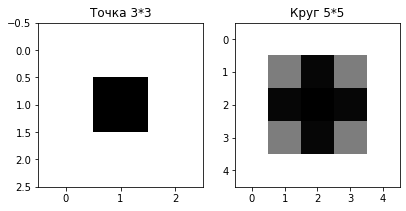

In [2]:
# Загружаем изображения шума
crc_img = cv2.cvtColor(cv2.imread('crc_img.png'), cv2.COLOR_BGR2GRAY)
sp_img = cv2.cvtColor(cv2.imread('sp_img.png'), cv2.COLOR_BGR2GRAY)

f.showOneLine([sp_img,crc_img], ['Точка 3*3','Круг 5*5'], size = (10, 5))

Уровни квантования: 2
.
Уровни квантования: 3
.


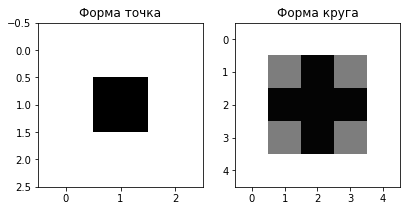

In [3]:
sp_f, sp_masks, sp_levels  = ma.relaxation(sp_img, threshold=0, N=1)
crc_f, crc_masks, crc_levels  = ma.relaxation(crc_img, threshold=0, N=1)
f.showOneLine([sp_f[0], crc_f[0]], ['Форма точка','Форма круга'], size = (10, 5))

### 2. Для каждого положения скользащего окна на анализируемом изображении вычисляется отношение

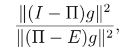

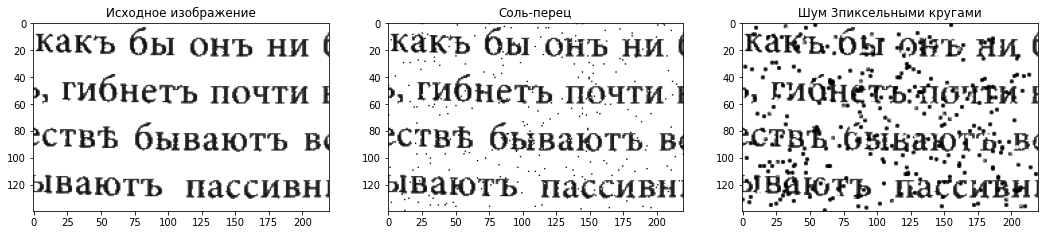

In [4]:
# Загружаем изображение
true_img,sp_img,crc_img = cv2.imread('text-d-true.png'),cv2.imread('text-d-sp.png'),cv2.imread('text-d-crc.png')
true_gray = cv2.cvtColor(true_img, cv2.COLOR_BGR2GRAY)
sp_gray= cv2.cvtColor(sp_img, cv2.COLOR_BGR2GRAY)
crc_gray = cv2.cvtColor(crc_img, cv2.COLOR_BGR2GRAY)

f.showOneLine([true_gray,sp_gray,crc_gray],['Исходное изображение','Соль-перец', 'Шум 3пиксельными кругами'] )

In [5]:
def color_var(window, masks):
    
    #Берем обратный цвет центра и закрашиваем предельным им
    main_color = 255- np.mean(window[masks[0]==1])
    if main_color > 128: main_color = 255
    else: main_color=0

    for mask in masks[:-1]:
        window[mask==1] = main_color   
    
    return window

def clear_window(window, img_masks, thr):
    E = np.ones(window.shape, dtype=np.uint8) * np.mean(window).astype(np.uint8)
    p, _ = ma.approximation(window,img_masks)
    diff1 = cv2.absdiff(p,window)
    diff2 = cv2.absdiff(p,E)
    
    diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))
    if diff < thr:
        window = color_var(window, img_masks)
    return window



In [6]:
def moving_window(img, action, *args, w_size= (3, 3), ):
    s, k = w_size
    n, m = img.shape
    image = img.copy()

    # Создим новое изображение белого цвета с большими размерами
    n, m = n + 2, m + 2
    extended_image = (np.ones((n, m), dtype=np.uint8)*255).astype(np.uint8)
    # Вставьте исходное изображение в центре расширенного изображения
    extended_image[1: n-1, 1: m-1] = image

    # Пройдемся по изображению с помощью скользящего окна
    for i in range(0, n - s + 1):
        for j in range(0, m - k + 1):
            # Выделим текущее окно
            window = extended_image[i:i + s, j:j + k]
            extended_image[i:i + s, j:j + k] = action(window, *args)

    return extended_image[1: n-1, 1: m-1]
           

### Расшифровка и подсчет ошибок соли/перца

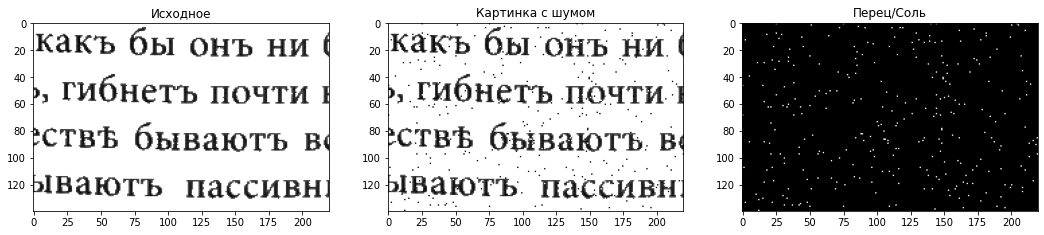

In [7]:
_, old_dots = cv2.threshold(cv2.absdiff(true_gray, sp_gray), 128, 255, cv2.THRESH_BINARY)

f.showOneLine([true_gray,  sp_gray, old_dots],['Исходное','Картинка с шумом', 'Перец/Соль'],dim=3 )

In [8]:
def count_lost_wrong(true, clear, noise_img, old_noise, show = False):

    _, new_noise = cv2.threshold(cv2.absdiff(true, clear), 128, 255, cv2.THRESH_BINARY)

    lost = old_noise- (255 - new_noise)
    wrong = new_noise - ( old_noise)

    if show:
        f.showOneLine([true, old_noise, lost,noise_img, new_noise, wrong],['Исходное', 'Изначальный шум', 'Пропущенный','Шум','Оставшийся шум', 'Ложный'],dim=3 )

    return len(lost[lost==255]), len(wrong[wrong==255])  

#salt, paper = define_salt_paper(true_img, true_binary, sp_clear_b, show=True)


C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))
C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


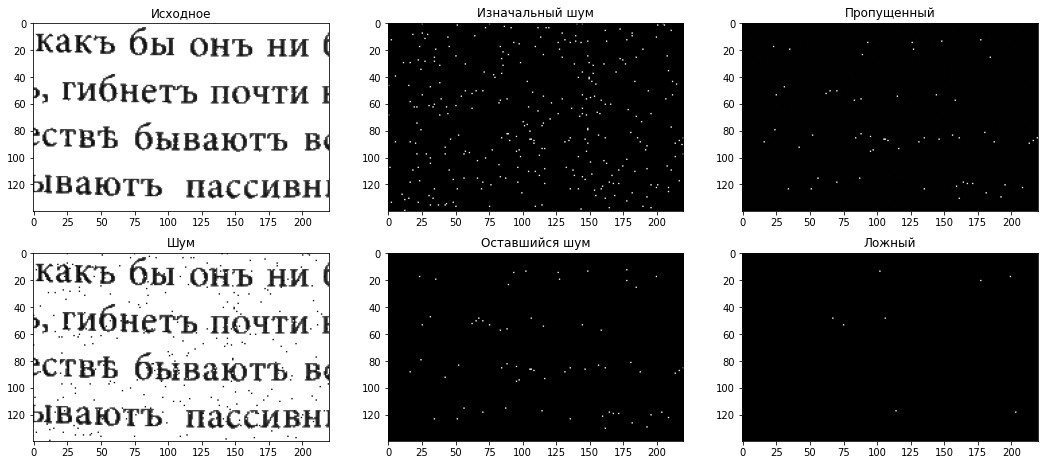

(57, 8)

In [9]:
count_lost_wrong(true_gray,moving_window(sp_gray, clear_window,sp_masks,1.42), sp_gray,old_dots,show=True)

Ищем лучшее пороговое значение

C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))
C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


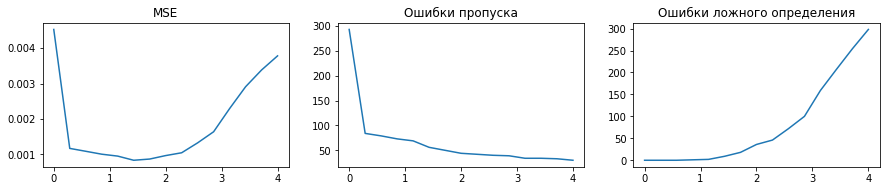

In [10]:
# Определим размер окна
window = sp_masks[0].shape  

x_range = np.linspace(0,4,15)
y_errors, lost_error, wrong_error = [], [], []

for trh in x_range:
    sp_clear = moving_window(sp_gray, clear_window,sp_masks,trh)
    #Квадратичное отклонение
    y_errors.append(old.mseImages(true_gray, sp_clear)) 
    
    #Ошибки перца и соли
    l, w = count_lost_wrong(true_gray,sp_clear, sp_gray,old_dots)
    lost_error.append(l)
    wrong_error.append(w)
    

plt.figure(figsize=(15,9))
for i, (error, text) in enumerate(zip([y_errors,lost_error,wrong_error], ['MSE','Ошибки пропуска','Ошибки ложного определения'])):
    plt.subplot(3, 3, i+1)
    plt.title(text)
    plt.plot(x_range,error)
plt.show()


C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))
C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: divide by zero encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


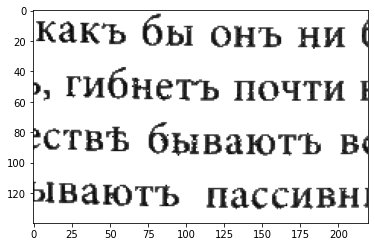

In [11]:
# Определим размер окна
threshold = 1.43

sp_clear = moving_window(sp_gray, clear_window,sp_masks,threshold)
plt.imshow(cv2.cvtColor(sp_clear, cv2.COLOR_BGR2RGB))


sp_clear - 0.0008333785207487631
sp_dilated_comb - 0.012825964788767557


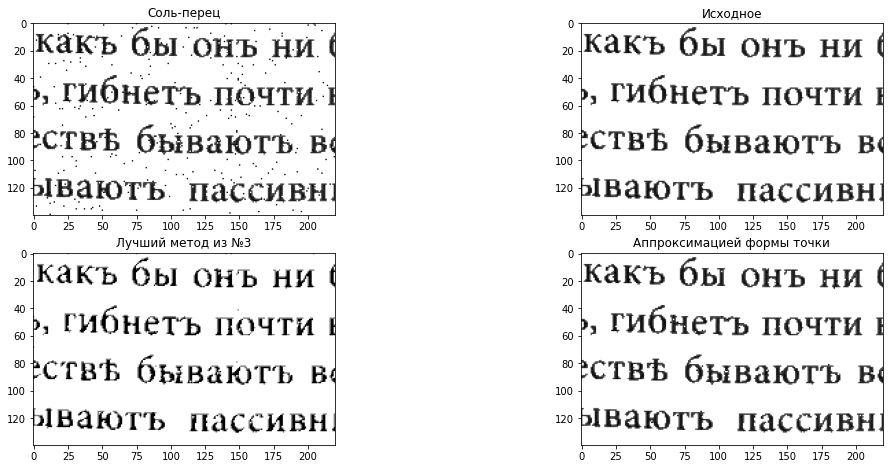

In [12]:
_, true_binary = cv2.threshold(true_gray, 128, 255, cv2.THRESH_BINARY)
_, sp_binary = cv2.threshold(sp_gray, 128, 255, cv2.THRESH_BINARY)

kernel_x = np.ones((1, 2), np.uint8) 
kernel_y = np.ones((2, 1), np.uint8)
sp_dilated_x, sp_dilated_y,sp_dilated_comb  = old.comboDilate(sp_binary, kernel_x, kernel_y)

print('sp_clear -',old.mseImages(true_gray, sp_clear))
print('sp_dilated_comb -',old.mseImages(true_binary, sp_dilated_comb))

f.showOneLine([sp_gray, true_gray, sp_dilated_comb, sp_clear],['Соль-перец','Исходное','Лучший метод из №3','Аппроксимацией формы точки'], dim = 2 )

### Круги

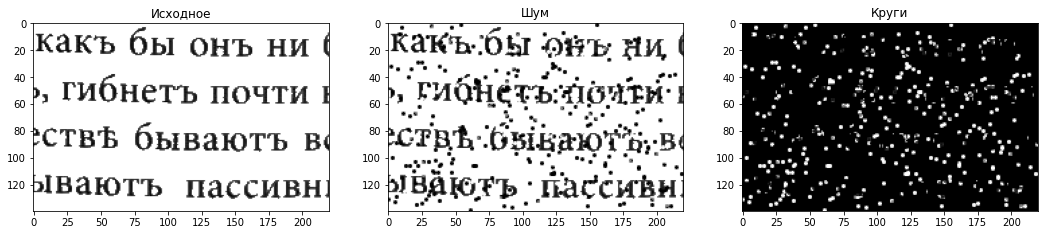

In [13]:
crc_old_dots = cv2.absdiff(true_gray, crc_gray)

f.showOneLine([true_gray,  crc_gray, crc_old_dots],['Исходное','Шум', 'Круги'],dim=3 )

In [14]:
def crc_count_lost_wrong(true, clear, noise_img, old_noise, show = False):

    old_noise = old_noise.astype(np.int16)
    new_noise = cv2.absdiff(true, clear).astype(np.int16)

    lost = old_noise - (255 - new_noise)
    lost = np.clip(lost, 0, 255).astype(np.uint8)
    wrong = new_noise - ( old_noise)
    wrong= np.clip(wrong, 0, 255).astype(np.uint8)

    if show:
        f.showOneLine([noise_img, old_noise.astype(np.uint8), lost,clear, new_noise.astype(np.uint8), wrong],['Изначальный шум', 'Шум', 'Пропущенный','Чистое','Оставшийся шум', 'Ложный'],dim=3 )

    return np.sqrt(np.sum(lost)), np.sqrt(np.sum(wrong))  

C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


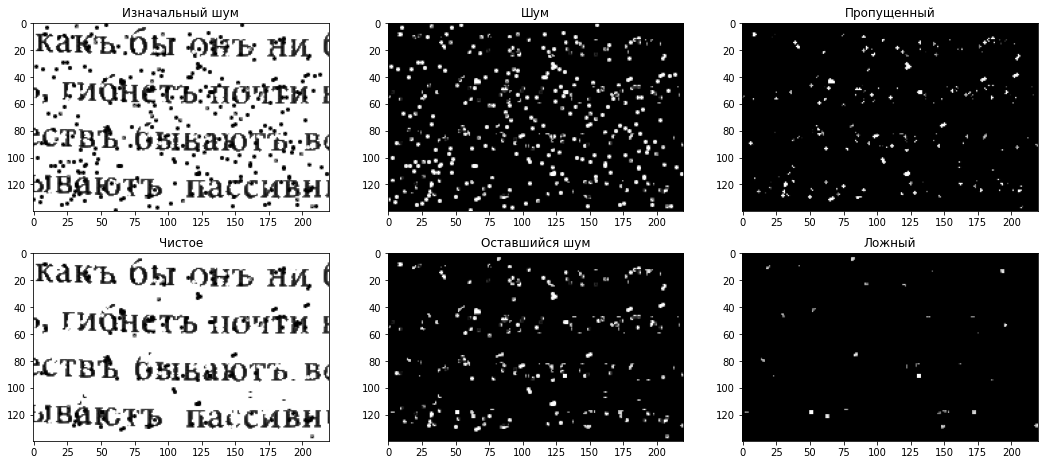

(352.72085280005774, 165.03030024816655)

In [15]:
crc_count_lost_wrong(true_gray,moving_window(crc_gray, clear_window,crc_masks,0.89, w_size= (5,5)), crc_gray,crc_old_dots,show=True)

C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


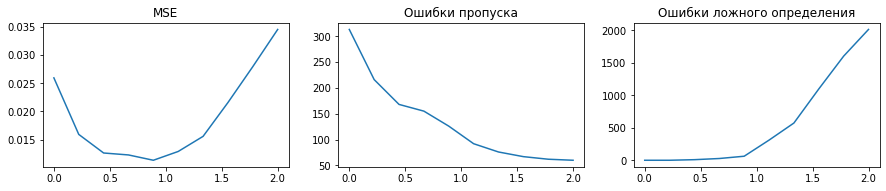

In [16]:
# Определим размер окна
window = crc_masks[0].shape  

x_range = np.linspace(0,2,10)
y_errors, lost_error, wrong_error = [], [], []

for trh in x_range:
    crc_clear = moving_window(crc_gray, clear_window,crc_masks,trh,w_size=(5,5))
    #Квадратичное отклонение
    y_errors.append(old.mseImages(true_gray, crc_clear)) 
    
    #Ошибки перца и соли
    l, w = count_lost_wrong(true_gray,crc_clear, crc_gray,crc_old_dots)
    lost_error.append(l)
    wrong_error.append(w)
    

plt.figure(figsize=(15,9))
for i, (error, text) in enumerate(zip([y_errors,lost_error,wrong_error], ['MSE','Ошибки пропуска','Ошибки ложного определения'])):
    plt.subplot(3, 3, i+1)
    plt.title(text)
    plt.plot(x_range,error)
plt.show()


In [17]:
# Определим размер окна
threshold = 0.89

crc_clear = moving_window(crc_gray, clear_window,crc_masks,threshold, w_size= (5,5))


C:\Users\golev\AppData\Local\Temp\ipykernel_29596\1063807995.py:19: RuntimeWarning: invalid value encountered in double_scalars
  diff =  np.square(np.linalg.norm(diff1))/np.square(np.linalg.norm(diff2))


crc_clear - 0.011393185937476596
crc_smoothed_image_b - 0.04623376623376623


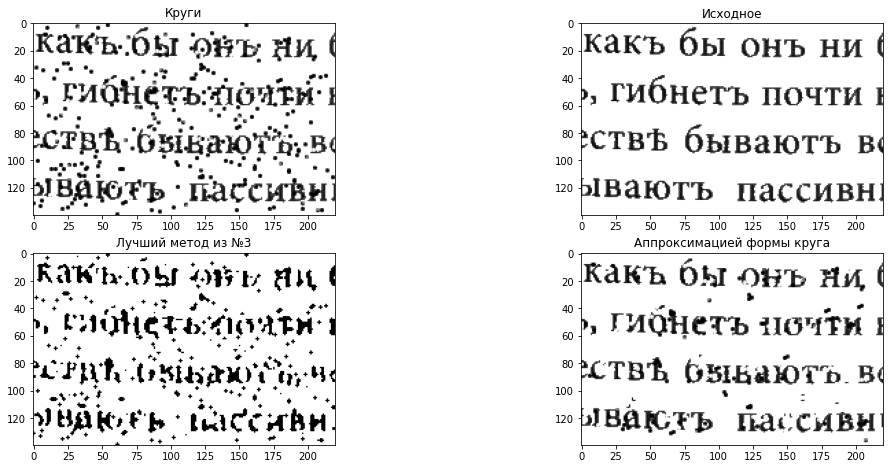

In [18]:
kernel_size_2 = (3, 3)

crc_smoothed_image = cv2.blur(crc_gray, kernel_size_2)
_, crc_smoothed_image_b = cv2.threshold(crc_smoothed_image, 128, 255, cv2.THRESH_BINARY)

print('crc_clear -',old.mseImages(true_gray, crc_clear))
print('crc_smoothed_image_b -',old.mseImages(true_binary, crc_smoothed_image_b))

f.showOneLine([crc_gray, true_gray, crc_smoothed_image_b, crc_clear],['Круги','Исходное','Лучший метод из №3','Аппроксимацией формы круга'], dim = 2)